In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

import hetnet_ml.src.graph_tools as gt
from tools.processing import expand_col_on_char
from hetnet_ml.src.extractor import MatrixFormattedGraph

tqdm.pandas()

In [2]:
colors = sns.color_palette(["#4f8c9d", "#e23209", "#77be20", "#a34ddf", "#34f50e", "#871d32", "#18d19b"])

In [5]:
load_dir = Path('../2_pipeline/01_Building_a_network_from_CTD/out').resolve()

In [6]:
nodes = gt.remove_colons(pd.read_csv(load_dir.joinpath('nodes_filt.csv'), dtype=str))

# Get the right datatype for each column before reading
# Default to string, but some are numeric, so change where needed
e_dtypes = {e: str for e in pd.read_csv(load_dir.joinpath('edges.csv'), nrows=0).columns}
e_dtypes['corrected_pvalue'] = float

edges = gt.remove_colons(pd.read_csv(load_dir.joinpath('edges.csv'), dtype=e_dtypes))

In [7]:
combo = gt.combine_nodes_and_edges(nodes, edges)

In [8]:
combo.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,corrected_pvalue,inference_gene_symbol,start_name,end_name,start_label,end_label
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,CTD,curated,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,CTD,curated,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene


In [9]:
combo[['direction', 'action']] = combo['parent_ixn'].str.split('^', expand=True)

# Metagraph of CTD

![CTD-Metagraph](../2_pipeline/01_Building_a_network_from_CTD/out/CTD_metagraph.png)

In [10]:
abv, et = gt.get_abbrev_dict_and_edge_tuples(nodes, edges)

In [11]:
abv_to_full = {v: k for k, v in abv.items()}

In [12]:
c_mapper = {n: i for i, n in enumerate(nodes['label'].unique())}

In [13]:
def plot_avg_deg_for_kind(kind):

    this_edges = combo.query('start_label == @kind or end_label == @kind')
    avg_deg = this_edges['type'].value_counts() / nodes['label'].value_counts()[kind]
    avg_deg = avg_deg.reset_index()

    n_edges = len(avg_deg)
    
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 4+int(n_edges / 6))

    sns.barplot(x='type', y='index', data=avg_deg, color=colors[c_mapper[kind]], ax=ax)
    plt.xlabel('Average degree')
    plt.ylabel('Edge Type')
    plt.title('Average Degree by edge type in {}'.format(kind));

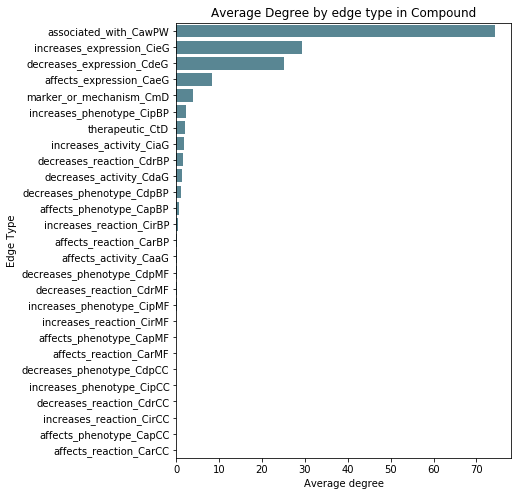

In [14]:
plot_avg_deg_for_kind('Compound')

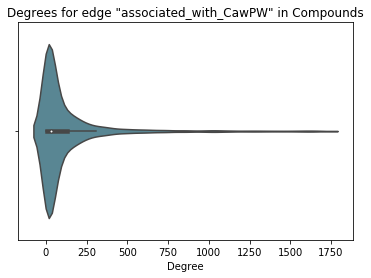

In [15]:
sns.violinplot(combo.query('type == "associated_with_CawPW"')['start_id'].value_counts(), 
               color=colors[c_mapper['Compound']])

plt.xlabel('Degree')
plt.title('Degrees for edge "associated_with_CawPW" in Compounds');

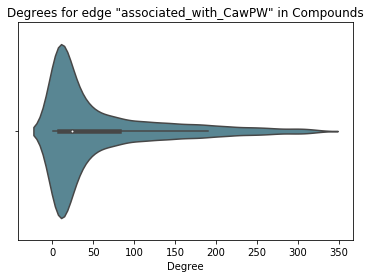

In [16]:
c = combo.query('type == "associated_with_CawPW"')['start_id'].value_counts()
sns.violinplot(c.tail(int(len(c)*.9)), color=colors[c_mapper['Compound']])

plt.xlabel('Degree')
plt.title('Degrees for edge "associated_with_CawPW" in Compounds');

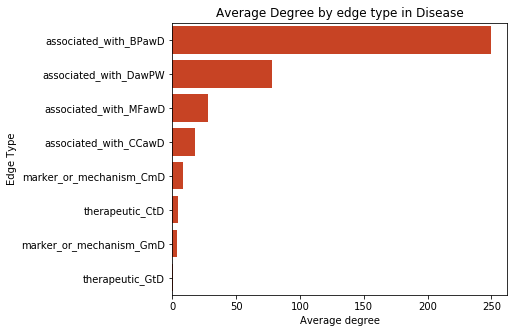

In [17]:
plot_avg_deg_for_kind('Disease')

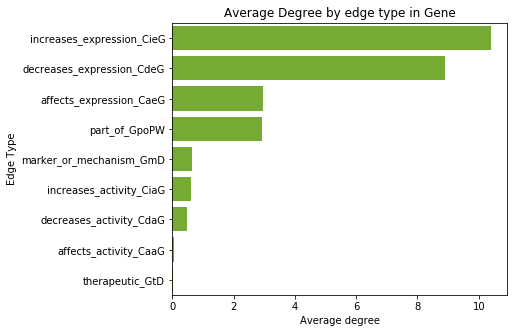

In [18]:
plot_avg_deg_for_kind('Gene')

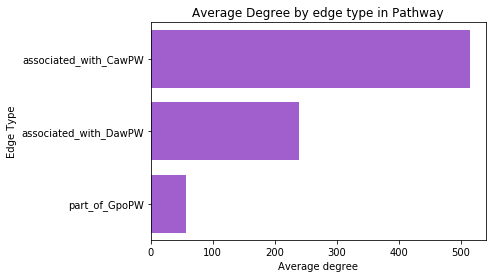

In [19]:
plot_avg_deg_for_kind('Pathway')

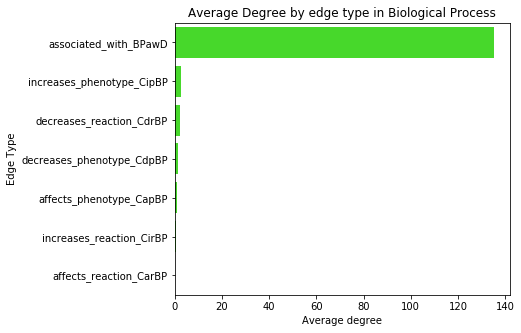

In [20]:
plot_avg_deg_for_kind('Biological Process')

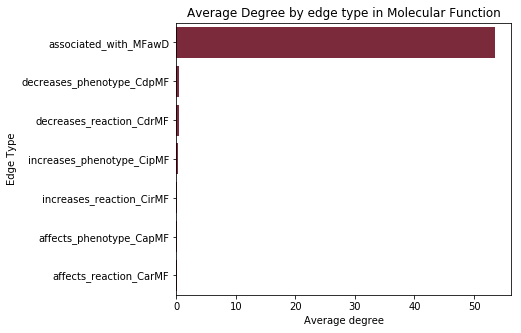

In [21]:
plot_avg_deg_for_kind('Molecular Function')

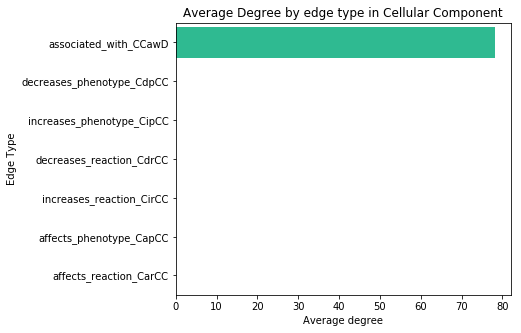

In [22]:
plot_avg_deg_for_kind('Cellular Component')

# Direction for same action

In [23]:
data = combo.query('start_label == "Compound" and end_label == "Gene"')
data = data.groupby(['start_id', 'end_id', 'action'])
data = data['direction'].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))

100%|██████████| 978012/978012 [01:53<00:00, 8606.71it/s]


In [24]:
data = data.reset_index()
data.head(2)

,start_id,end_id,action,direction
0,MESH:C000121,4313,activity,Decreases
1,MESH:C000121,4313,expression,Decreases


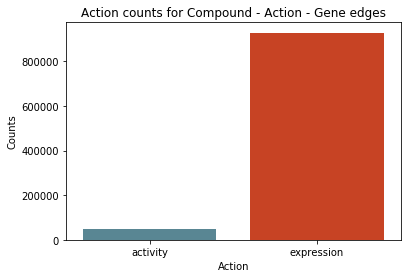

In [25]:
sns.countplot(x='action', data=data, palette=colors)
plt.xlabel('Action')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Gene edges');

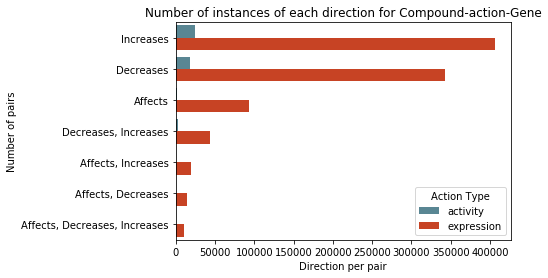

In [26]:
order = data['direction'].value_counts().index.tolist()
sns.countplot(y='direction', data=data, hue='action', order=order, palette=colors)
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Action Type')
plt.title('Number of instances of each direction for Compound-action-Gene');

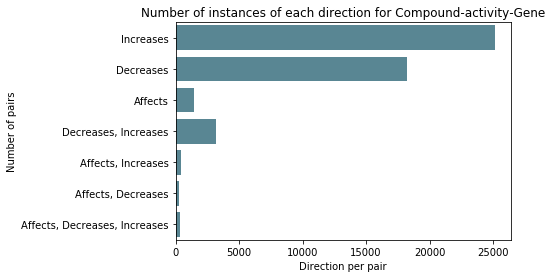

In [27]:
sns.countplot(y='direction', data=data.query('action == "activity"'), order=order, color=colors[0])
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each direction for Compound-activity-Gene');

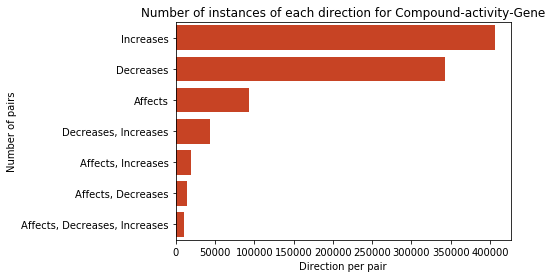

In [28]:
sns.countplot(y='direction', data=data.query('action == "expression"'), order=order, color=colors[1])
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each direction for Compound-activity-Gene');

## Activity, vs Expression in same direciton

In [29]:
test = combo.query('start_label == "Compound" and end_label == "Gene"')
test = test.groupby(['start_id', 'end_id', 'direction'])
test = test['action'].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))

100%|██████████| 1065954/1065954 [02:03<00:00, 8606.21it/s]


In [30]:
test = test.reset_index()

In [31]:
test.head(2)

,start_id,end_id,direction,action
0,MESH:C000121,4313,decreases,"Activity, Expression"
1,MESH:C000121,4318,decreases,"Activity, Expression"


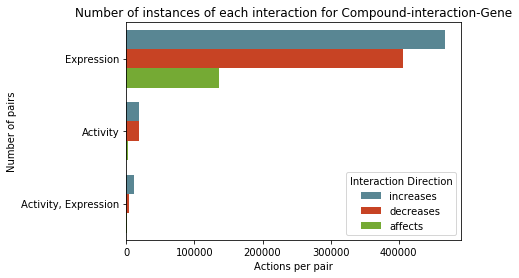

In [32]:
order = ['Expression', 'Activity', 'Activity, Expression']
h_order = ['increases', 'decreases', 'affects']

sns.countplot(y='action', data=test, hue='direction', order=order, hue_order=h_order, palette=colors)
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Interaction Direction')
plt.title('Number of instances of each interaction for Compound-interaction-Gene');

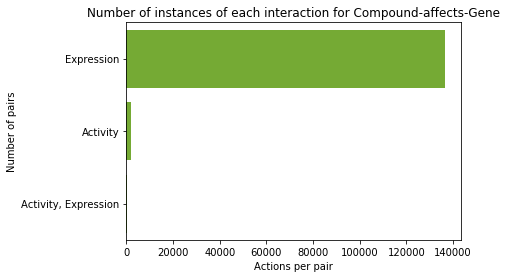

In [33]:
sns.countplot(y='action', data=test.query('direction == "affects"'), color=colors[2])
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each interaction for Compound-affects-Gene');

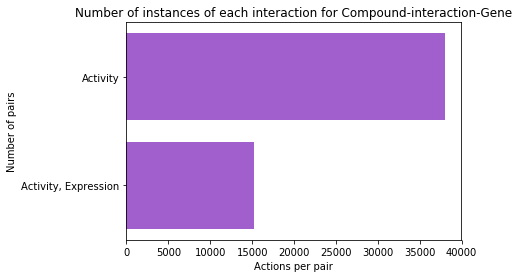

In [34]:
sns.countplot(y='action', data=test.query('action != "Expression"'), order=order[1:], color=colors[3])
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.title('Number of instances of each interaction for Compound-interaction-Gene');

# Similar Analysis on compounds to GO-Terms

In [35]:
def group_terms(combo_df, start_type, end_type, group_on, count_col):
    data = combo_df.query('start_label == @start_type and end_label == @end_type')
    data = data.groupby(['start_id', 'end_id', group_on])
    data = data[count_col].progress_apply(lambda c: ', '.join([s.capitalize() for s in c]))
    return data.reset_index()

In [36]:
bp_directions = group_terms(combo, 'Compound', 'Biological Process', 'action', 'direction')

100%|██████████| 88726/88726 [00:10<00:00, 8589.37it/s]


In [37]:
bp_directions.head()

,start_id,end_id,action,direction
0,MESH:C000121,GO:0008283,phenotype,Decreases
1,MESH:C000121,GO:0016477,phenotype,Decreases
2,MESH:C000152,GO:0006702,phenotype,Decreases
3,MESH:C000152,GO:0008284,phenotype,"Decreases, Increases"
4,MESH:C000152,GO:0008284,reaction,Decreases


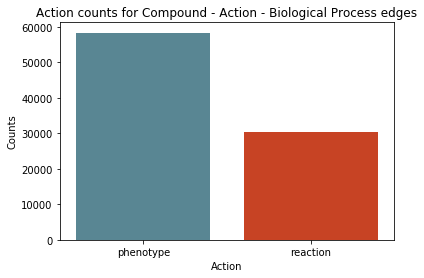

In [38]:
sns.countplot(x='action', data=bp_directions, palette=colors)
plt.xlabel('Action')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Biological Process edges');

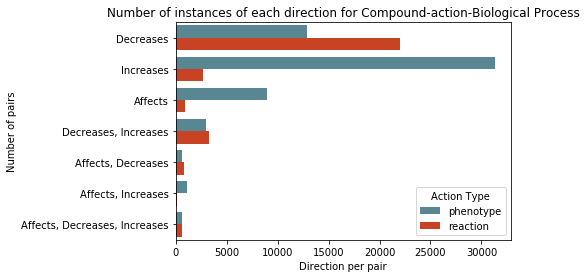

In [39]:
order = bp_directions['direction'].value_counts().index.tolist()
sns.countplot(y='direction', data=bp_directions, hue='action', order=order, palette=colors)
plt.xlabel('Direction per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Action Type')
plt.title('Number of instances of each direction for Compound-action-Biological Process');

In [40]:
bp_actions = group_terms(combo, 'Compound', 'Biological Process', 'direction', 'action')
bp_actions.head(2)

100%|██████████| 86783/86783 [00:10<00:00, 8584.81it/s]


,start_id,end_id,direction,action
0,MESH:C000121,GO:0008283,decreases,Phenotype
1,MESH:C000121,GO:0016477,decreases,Phenotype


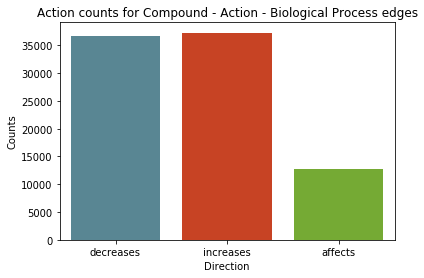

In [41]:
sns.countplot(x='direction', data=bp_actions, palette=colors)
plt.xlabel('Direction')
plt.ylabel('Counts')
plt.title('Action counts for Compound - Action - Biological Process edges');

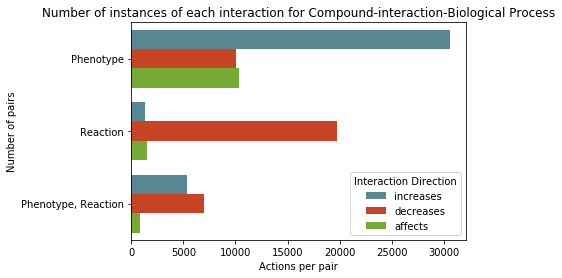

In [42]:
h_order = ['increases', 'decreases', 'affects']
order = bp_actions['action'].value_counts().index.tolist()

sns.countplot(y='action', data=bp_actions, hue='direction', order=order, hue_order=h_order, palette=colors)
plt.xlabel('Actions per pair')
plt.ylabel('Number of pairs')
plt.legend(title='Interaction Direction')
plt.title('Number of instances of each interaction for Compound-interaction-Biological Process');

# Taxonomy

In [43]:
combo.dropna(subset=['organism_id'])['abbv'].value_counts()

CieG     477850
CdeG     409177
CaeG     136927
CipBP     35350
CiaG      27963
CdrBP     26393
CdaG      19831
CdpBP     16652
CapBP     10941
CirBP      6596
CarBP      2351
CaaG       2160
CdpMF      1773
CdrMF      1647
CipMF      1326
CirMF       220
CapMF       187
CarMF       176
CdpCC        44
CipCC        40
CdrCC        29
CirCC        12
CapCC         9
CarCC         2
Name: abbv, dtype: int64

In [44]:
tax_exp = expand_col_on_char(combo.dropna(subset=['organism_id']), 'organism_id', '|')

In [45]:
tax_exp.head(2)

,start_id,end_id,type,parent_ixn,pub_med_ids,organism_id,abbv,source,evidence,direct_evidence,corrected_pvalue,inference_gene_symbol,start_name,end_name,start_label,end_label,direction,action
0,MESH:C000121,4313,decreases_activity_CdaG,decreases^activity,25899827,9606,CdaG,CTD,curated,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene,decreases,activity
1,MESH:C000121,4313,decreases_expression_CdeG,decreases^expression,25899827,9606,CdeG,CTD,curated,NaN,NaN,NaN,pipoxolan,matrix metallopeptidase 2,Compound,Gene,decreases,expression


In [46]:
from wikidataintegrator.wdi_core import WDItemEngine

In [47]:
q = """
SELECT ?tax_name ?tax_id
WHERE 
{
  ?item wdt:P225 ?tax_name.
  ?item wdt:P31 wd:Q16521. 
  ?item wdt:P685 ?tax_id.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

res = WDItemEngine.execute_sparql_query(q, as_dataframe=True)

In [48]:
res.head(2)

,tax_id,tax_name
0,4751,Fungi
1,4231,Helianthus


In [49]:
tax_map = res.set_index('tax_id')['tax_name'].to_dict()
tax_exp['name'] = tax_exp['organism_id'].map(tax_map)

In [50]:
tax_exp['name'].value_counts().head()

Homo sapiens              508620
Mus musculus              318375
Rattus norvegicus         284866
Danio rerio                53872
Caenorhabditis elegans     11837
Name: name, dtype: int64

In [51]:
tax_grp = group_terms(tax_exp.dropna(subset=['name']), 'Compound', 'Gene', 'type', 'organism_id')

100%|██████████| 1073764/1073764 [02:04<00:00, 8617.39it/s]


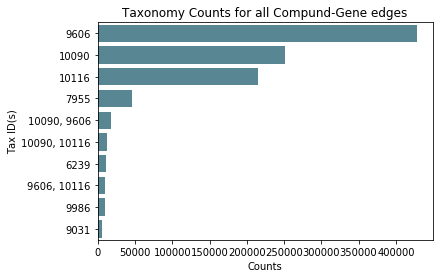

In [52]:
top_tax = tax_grp['organism_id'].value_counts().head(10).index.tolist()

sns.countplot(y='organism_id', data=tax_grp.query('organism_id in @top_tax'), order=top_tax, color=colors[0])
plt.xlabel('Counts')
plt.ylabel('Tax ID(s)')
plt.title('Taxonomy Counts for all Compund-Gene edges');

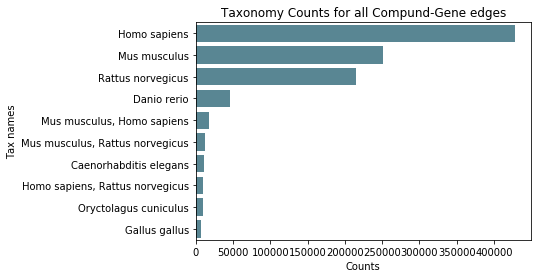

In [53]:
tax_grp['name'] = tax_grp['organism_id'].apply(lambda i: ', '.join(map(lambda t: tax_map[t], i.split(', '))))

top_tax = tax_grp['name'].value_counts().head(10).index.tolist()

sns.countplot(y='name', data=tax_grp.query('name in @top_tax'), order=top_tax, color=colors[0])
plt.xlabel('Counts')
plt.ylabel('Tax names')
plt.title('Taxonomy Counts for all Compund-Gene edges');

# PMID Counts

In [54]:
pmid_counts = combo.dropna(subset=['pub_med_ids'])['pub_med_ids'].apply(lambda s: s.count('|')+1)

In [55]:
max(pmid_counts)

732

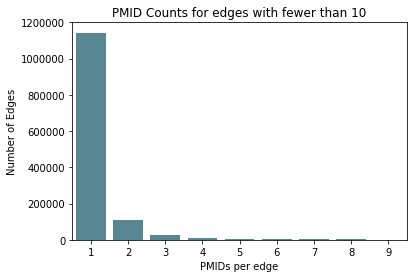

In [56]:
sns.countplot(x=pmid_counts[pmid_counts < 10], color=colors[0])
plt.xlabel('PMIDs per edge')
plt.ylabel('Number of Edges')
plt.title('PMID Counts for edges with fewer than 10');

In [57]:
combo.dropna(subset=['pub_med_ids'])['abbv'].unique()

array(['CdaG', 'CdeG', 'CiaG', 'CieG', 'CaeG', 'CaaG', 'CtD', 'CmD',
       'GmD', 'GtD', 'CdpBP', 'CdrBP', 'CipBP', 'CapBP', 'CdpMF', 'CipMF',
       'CdrMF', 'CirBP', 'CdpCC', 'CdrCC', 'CarBP', 'CipCC', 'CirMF',
       'CarMF', 'CapMF', 'CirCC', 'CapCC', 'CarCC'], dtype=object)

# Evidence Counts

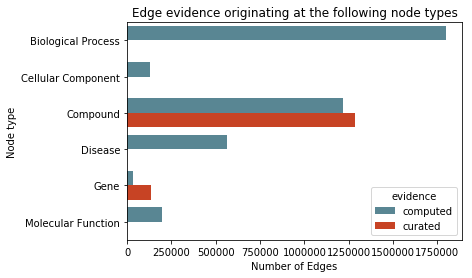

In [79]:
data  = combo.groupby('start_label')['evidence'].value_counts().rename('count').to_frame().reset_index()
ax = sns.barplot(x='count', y='start_label', data=data, hue='evidence', palette=sns.color_palette(colors))
ax.set_title('Edge evidence originating at the following node types')
ax.set_xlabel('Number of Edges')
ax.set_ylabel('Node type');

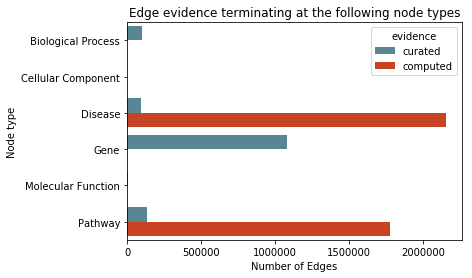

In [82]:
data  = combo.groupby('end_label')['evidence'].value_counts().rename('count').to_frame().reset_index()
ax = sns.barplot(x='count', y='end_label', data=data, hue='evidence', palette=colors)
ax.set_title('Edge evidence terminating at the following node types')
ax.set_xlabel('Number of Edges')
ax.set_ylabel('Node type');